In [5]:
import re
import datetime
import urllib.request
import io
import math
from datetime import date
import json

import torch
from Bio import Phylo
import pandas as pd
import matplotlib.pyplot as plt
from augur.utils import json_to_tree

import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel
from pyro.contrib.epidemiology.models import SuperspreadingSEIRModel
from pyro.contrib.epidemiology.distributions import binomial_dist, infection_dist

pyro.enable_validation(True)
torch.set_default_dtype(torch.double)
torch.set_printoptions(precision=2)
print(torch.__version__)
print(pyro.__version__)

1.6.0
1.4.0


# Information Parsing
<hr>

### Parse timetree phylogeny and find clades

In [29]:
# with auspice JSONs
region = "california"
tree_json = f"../jsons/ncov_{region}.json"
tree_newick = f"../timetrees/tree_{region}.nwk"

def get_phylogeny(tree_path, tree_type="newick"):
    if tree_type == "newick":   
        with open(tree_newick) as f:
            for phylogeny in Phylo.parse(f, "newick"):
                break
            return phylogeny
    
    elif tree_type == "auspice_json":
        with open(tree_json) as f:
                tree = json.load(f)

        phylogeny = json_to_tree(tree)
        return phylogeny
    
    else:
        raise ValueError(
            f"current tree_type {tree_type} not supported"
        )
    
# phylogeny_auspice = get_phylogeny(tree_json, tree_type="auspice_json")
phylogeny_newick = get_phylogeny(tree_newick, tree_type="newick")

In [101]:
metadata = pd.read_csv("../gisaid/metadata.tsv", sep="\t")
print(metadata.shape)
metadata.head()

(92079, 26)


,strain,virus,gisaid_epi_isl,genbank_accession,date,region,country,division,location,region_exposure,...,sex,pangolin_lineage,GISAID_clade,originating_lab,submitting_lab,authors,url,title,paper_url,date_submitted
0,Algeria/G0638_2264/2020,ncov,EPI_ISL_418241,?,2020-03-02,Africa,Algeria,Boufarik,NaN,Africa,...,NaN,B.1,GH,NIC Viral Respiratory Unit - Institut Pasteur ...,National Reference Center for Viruses of Respi...,Mélanie Albert et al,https://www.gisaid.org,?,?,2020-03-29
1,Algeria/G0640_2265/2020,ncov,EPI_ISL_418242,?,2020-03-08,Africa,Algeria,Blida,NaN,Africa,...,NaN,B.1,GH,NIC Viral Respiratory Unit - Institut Pasteur ...,National Reference Center for Viruses of Respi...,Mélanie Albert et al,https://www.gisaid.org,?,?,2020-03-29
2,Algeria/G0860_2262/2020,ncov,EPI_ISL_420037,?,2020-03-02,Africa,Algeria,Boufarik,NaN,Africa,...,NaN,B.1,GH,NIC Viral Respiratory Unit - Institut Pasteur ...,National Reference Center for Viruses of Respi...,Mélanie Albert et al,https://www.gisaid.org,?,?,2020-04-04
3,Anhui/SZ005/2020,ncov,EPI_ISL_413485,?,2020-01-24,Asia,China,Anhui,Suzhou,Asia,...,NaN,A,O,"Department of microbiology laboratory,Anhui Pr...","Department of microbiology laboratory,Anhui Pr...",Weiwei Li et al,https://www.gisaid.org,?,?,2020-03-05
4,Argentina/C121/2020,ncov,EPI_ISL_420600,?,2020-03-07,South America,Argentina,Argentina,NaN,South America,...,NaN,B.1.1,GR,Servicio Virosis Respiratorias-Departamento Vi...,Instituto Nacional Enfermedades Infecciosas C....,Baumeister E. et al,https://www.gisaid.org,COVID-19 in Latin America: Contrasting phylody...,https://dx.doi.org/10.1101/2020.05.23.20111443,2020-04-06


In [121]:
strains = metadata.query(
    f"country == '{region.title()}' | \
    division == '{region.title()}'"
)["strain"].values
strains
# region_names[~region_names["strain"].str.contains("CA")]

array(['USA/CA-11567/2020', 'USA/CA-ALSR-0466-IPL/2020',
       'USA/CA-ALSR-0468-SAN/2020', ..., 'USA/NV-NSPHL-A0137/2020',
       'USA/NV-NSPHL-A0141/2020', 'USA/WA-S1179/2020'], dtype=object)

In [122]:
region = "california"
tree_newick = f"../timetrees/tree_{region}.nwk"

with open(tree_newick) as f:
    for phylogeny in Phylo.parse(f, "newick"):
        break

print(f"beginning terminal nodes {phylogeny.count_terminals()}")

internals = phylogeny.get_nonterminals()
for node in internals:
    if (not(node.name.startswith("NODE_"))&(node.name not in strains)):
        phylogeny.collapse(node)
        
terminals = phylogeny.get_terminals()
for node in terminals:
    if (node.name not in strains):
        phylogeny.prune(node)
        

print(f"ending terminal nodes {phylogeny.count_terminals()}")

beginning terminal nodes 8079
ending terminal nodes 1770


In [123]:
for node in phylogeny.find_clades():
    if node.is_terminal():
        print(node.name)

USA/CA-CSMC111/2020
USA/CA-CSMC132/2020
USA/CA-CSMC88/2020
USA/CA-CZB-1588/2020
USA/CA-CZB-1228/2020
USA/CA-CZB-1508/2020
USA/CA-QDX-148/2020
USA/CA-CSMC134/2020
USA/CA-QDX-111/2020
USA/CA-QDX-03/2020
USA/CA-CZB-1555/2020
USA/CA-SR0247/2020
USA/CA-CZB0721/2020
USA/CA-CSMC34/2020
USA/CA-QDX-154/2020
USA/CA-QDX-155/2020
USA/CA-QDX-79/2020
USA/CA-CZB0114/2020
USA/CA-CDPH018/2020
USA/CA-CSMC20/2020
USA/CA-CZB011b/2020
USA/CA-CZB076/2020
USA/CA-CZB0154/2020
USA/CA-QDX-78/2020
USA/CA-CZB-1716/2020
USA/CA-CDPH009/2020
USA/CA-CZB-1334/2020
USA/CA-CZB-1330/2020
USA/CA-CDPH002/2020
USA/CA-SR0443/2020
USA/CA-SR0436/2020
USA/CA-SCCPHD-UC152/2020
USA/CA-SCCPHD-UC140/2020
USA/CA-CDPH001/2020
USA/CA-ALSR-1499/2020
USA/CA-SR0311/2020
USA/CA-CZB-1576/2020
USA/CA-CZB-1584/2020
USA/CA-CZB-1586/2020
USA/CA-CZB-1620/2020
USA/CA-CZB-1603/2020
USA/CA-CZB-1391/2020
USA/CA-CZB-1608/2020
USA/CA-CZB-1601/2020
USA/CA-QDX-36/2020
USA/CA-CZB-1360/2020
USA/CA-CZB-1577/2020
USA/CA-CZB-1582/2020
USA/CA-CZB-1585/2020
U

In [7]:
# Fix a parsing error for whereby internal nodes interpret .name as .confidence
def fix_parsing_annotations(phylogeny):
    for clade in phylogeny.find_clades():
        if clade.confidence:
            clade.name = clade.confidence
            clade.confidence = None
            
#fix_parsing_annotations(phylogeny_auspice)
fix_parsing_annotations(phylogeny_newick)

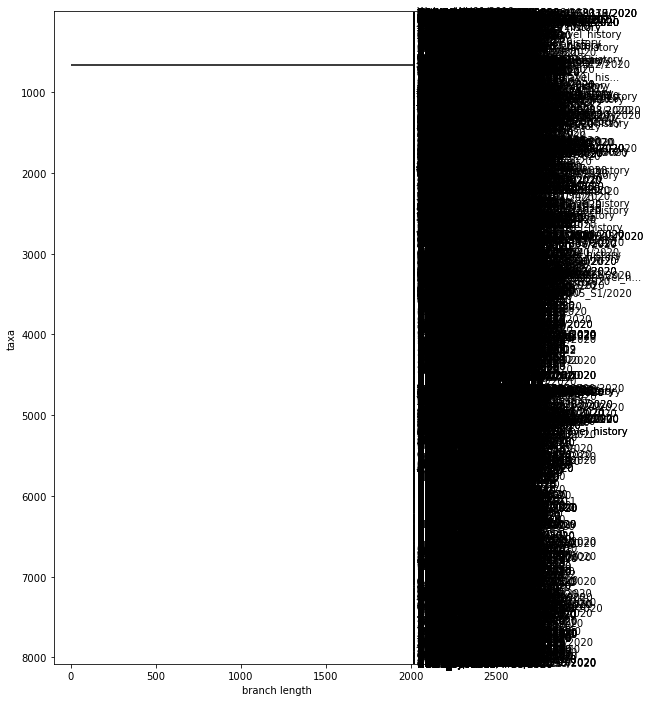

In [8]:
def draw_phylogeny(phylogeny):
    Phylo.draw(phylogeny, do_show=False)
    plt.gcf().set_figwidth(8)
    plt.gcf().set_figheight(12)
    

#draw_phylogeny(phylogeny_auspice)
draw_phylogeny(phylogeny_newick)

In [9]:
timeseries_path =f"../results/imputed_infection_dates/summary_{region}_timeseries_new_cases_value_counts.txt"
df = pd.read_csv(timeseries_path, sep=",")
print(df.shape)
df.head()

(274, 2)


,date,new_cases
0,2020-01-19,0
1,2020-01-20,0
2,2020-01-21,1
3,2020-01-22,0
4,2020-01-22,0


In [10]:
new_cases = list(df["new_cases"])
if new_cases[-1] == 0:
    new_cases.pop(-1)
new_cases = torch.tensor(new_cases, dtype=torch.double)
print(new_cases.sum())

tensor(886938.)


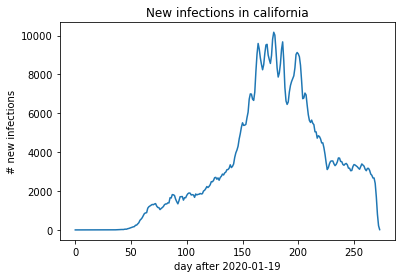

In [11]:
plt.plot(df["new_cases"])
plt.xlabel("day after {}".format(df["date"][0]))
plt.ylabel("# new infections")
plt.title("New infections in {}".format(region));

# Converting data inputs to PyTorch tensors

In [12]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [13]:
full_metadata = pd.read_csv("../gisaid/metadata.tsv", sep="\t")
metadata = full_metadata[full_metadata["strain"].isin([x.name for x in phylogeny_newick.get_terminals()])]
metadata["date"] = pd.to_datetime(metadata["date"])
metadata['decimal_date'] = metadata["date"].apply(toYearFraction)

<ipython-input-13-7d42be9dc88b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["date"] = pd.to_datetime(metadata["date"])
<ipython-input-13-7d42be9dc88b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['decimal_date'] = metadata["date"].apply(toYearFraction)


In [14]:
last_tip_date = metadata["decimal_date"].max()

In [15]:
leaf_times, coal_times = dist.coalescent.bio_phylo_to_times(phylogeny_newick)
shift = last_tip_date-max(leaf_times)
leaf_times = leaf_times + shift
coal_times = coal_times + shift

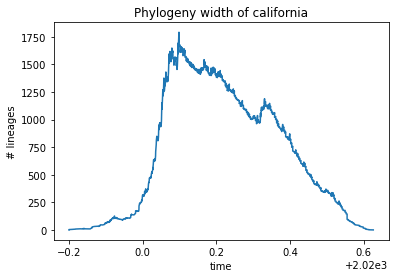

In [16]:
times = torch.cat([coal_times, leaf_times])
signs = torch.cat([-torch.ones_like(coal_times), torch.ones_like(leaf_times)])
times, index = times.sort(0)
signs = signs[index]
lineages = signs.flip([0]).cumsum(0).flip([0])

plt.plot(times, lineages)
plt.xlabel("time")
plt.ylabel("# lineages")
plt.title("Phylogeny width of {}".format(region));

In [20]:
model = SuperspreadingSEIRModel(population=int(4e7),
                                incubation_time=5.5,
                                recovery_time=14.,
                                data=new_cases,
                                leaf_times=leaf_times,
                                coal_times=coal_times)

mcmc = model.fit_mcmc(num_samples=200,
                 haar_full_mass=7)

INFO 	 Running inference...
Sample: 100%|██████████| 400/400 [00:27, 14.72it/s, step size=2.76e-05, acc. prob=0.956]


In [26]:
mcmc.summary().to_csv("output.csv")

# import csv

# with open('output.csv', 'w') as csvfile:
#     csvwriter = csv.writer(csvfile)
#     csvwriter.writerows(mcmc.summary())

# #dir(mcmc)


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
              R0      0.42      0.00      0.42      0.42      0.42      6.15      1.26
               k      0.35      0.00      0.35      0.35      0.35      5.17      1.16
             rho      0.23      0.00      0.23      0.23      0.23      2.53      2.64
  auxiliary[0,0] 39999998.27      0.00 39999998.27 39999998.27 39999998.27      3.01      2.00
  auxiliary[0,1] 39999987.07      0.00 39999987.07 39999987.07 39999987.07      5.74      1.01
  auxiliary[0,2] 39999985.78      0.00 39999985.78 39999985.78 39999985.78      2.83      2.19
  auxiliary[0,3] 39999983.60      0.00 39999983.60 39999983.60 39999983.60      5.28      1.05
  auxiliary[0,4] 39999983.97      0.00 39999983.97 39999983.97 39999983.97      7.59      1.02
  auxiliary[0,5] 39999981.32      0.00 39999981.32 39999981.31 39999981.32      4.84      1.02
  auxiliary[0,6] 39999975.81      0.00 39999975.81 39999975.81 39999975.81      4

AttributeError: 'NoneType' object has no attribute 'to_csv'

In [19]:
mcmc = mcmc.summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
              R0      3.00      0.00      3.00      2.99      3.00      3.30      1.87
               k      1.03      0.01      1.03      1.01      1.05      2.51      2.55
             rho      0.00      0.00      0.00      0.00      0.01      2.54      2.57
  auxiliary[0,0] 39999997.90      0.00 39999997.90 39999997.90 39999997.91      6.81      1.20
  auxiliary[0,1] 39999999.50      0.00 39999999.50 39999999.50 39999999.50     10.73      1.02
  auxiliary[0,2] 39999995.10      0.01 39999995.10 39999995.09 39999995.11      8.44      1.57
  auxiliary[0,3] 39999996.25      0.01 39999996.25 39999996.24 39999996.26      4.02      1.49
  auxiliary[0,4] 39999992.67      0.02 39999992.66 39999992.65 39999992.71      2.95      1.84
  auxiliary[0,5] 39999991.12      0.01 39999991.12 39999991.09 39999991.14      5.15      1.32
  auxiliary[0,6] 39999990.03      0.01 39999990.03 39999990.01 39999990.05      4

In [18]:
pd.to_csv(mcmc.summary(), sep="\t")


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
              R0      3.00      0.00      3.00      2.99      3.00      3.30      1.87
               k      1.03      0.01      1.03      1.01      1.05      2.51      2.55
             rho      0.00      0.00      0.00      0.00      0.01      2.54      2.57
  auxiliary[0,0] 39999997.90      0.00 39999997.90 39999997.90 39999997.91      6.81      1.20
  auxiliary[0,1] 39999999.50      0.00 39999999.50 39999999.50 39999999.50     10.73      1.02
  auxiliary[0,2] 39999995.10      0.01 39999995.10 39999995.09 39999995.11      8.44      1.57
  auxiliary[0,3] 39999996.25      0.01 39999996.25 39999996.24 39999996.26      4.02      1.49
  auxiliary[0,4] 39999992.67      0.02 39999992.66 39999992.65 39999992.71      2.95      1.84
  auxiliary[0,5] 39999991.12      0.01 39999991.12 39999991.09 39999991.14      5.15      1.32
  auxiliary[0,6] 39999990.03      0.01 39999990.03 39999990.01 39999990.05      4